In [1494]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
import wandb
import statistics
from sklearn.model_selection import train_test_split
# import autoinit

Initialize run

wandb initialization

In [1495]:
# run = wandb.init(project='prediction model for CT-masking')

Data

In [1496]:
df = pd.read_csv("data/filtered_ds.csv")
df

,id,patient_id,domain_ids,domain_scores,start_time_min
0,9256459,143524,1,0.0000,2017-12-02 13:28:49
1,9319566,143524,1,0.0000,2017-12-08 11:22:58
2,9346944,143524,1,0.0860,2017-12-11 11:47:19
3,9524559,143524,1,0.0860,2017-12-24 14:11:56
4,9525898,143524,1,0.0860,2017-12-24 16:38:01
...,...,...,...,...,...
2194129,19768354,312036,12,0.9000,2019-09-05 23:40:37
2194130,19770319,312036,12,0.9070,2019-09-20 03:42:08
2194131,20071746,312036,12,0.9070,2019-09-22 20:02:43
2194132,20160407,312036,12,0.9000,2019-09-26 19:52:09


In [1497]:
df = df.sort_values(by=["patient_id", "start_time_min"])

Create training data

In [1498]:
def process_row(row):
    values_a = [float(x.strip()) for x in str(row['domain_ids']).split(',')]
    values_b = [float(x.strip()) for x in str(row['domain_scores']).split(',')]
    return values_a, values_b

In [1499]:
def create_training_data(data : pd.DataFrame):
    score = np.zeros((1,14))
    scores = np.zeros((len(data), 14))
    i = 0

    for idx, row in data.iterrows():
        domains, domain_scores = process_row(row)
        for j in range(len(domains)):
            score[0, int(domains[j] - 1)] = domain_scores[j]
        # set score to the score list average
        scores[i] = score
        i += 1
    
    scores_df = pd.DataFrame(scores, columns=["domain %d score" % i for i in range(1, 15)])
    data.reset_index(drop=True, inplace=True)
    scores_df.reset_index(drop=True, inplace=True)
    data = pd.concat([data, scores_df], axis=1)
    return data

In [1500]:
data = df.groupby("patient_id").apply(create_training_data).reset_index(drop=True)

/var/folders/vv/6vndbrvd7r1gc7xq3qqx8tfh0000gq/T/ipykernel_89187/1806359856.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = df.groupby("patient_id").apply(create_training_data).reset_index(drop=True)


In [1501]:
data

,id,patient_id,domain_ids,domain_scores,start_time_min,domain 1 score,domain 2 score,domain 3 score,domain 4 score,domain 5 score,domain 6 score,domain 7 score,domain 8 score,domain 9 score,domain 10 score,domain 11 score,domain 12 score,domain 13 score,domain 14 score
0,9316748,14696,"1,13","0.5850,0.7030",2017-12-06 14:20:08,0.585,0.0,0.00,0.000,0.000,0.0,0.0,0.0,0.00,0.000,0.0,0.000,0.703,0.0
1,9316749,14696,"4,5","0.6430,0.4500",2017-12-06 14:27:53,0.585,0.0,0.00,0.643,0.450,0.0,0.0,0.0,0.00,0.000,0.0,0.000,0.703,0.0
2,9316750,14696,9,0.9500,2017-12-06 14:38:16,0.585,0.0,0.00,0.643,0.450,0.0,0.0,0.0,0.95,0.000,0.0,0.000,0.703,0.0
3,9316751,14696,10,0.8070,2017-12-06 14:44:54,0.585,0.0,0.00,0.643,0.450,0.0,0.0,0.0,0.95,0.807,0.0,0.000,0.703,0.0
4,9316752,14696,"12,13","0.5070,0.7030",2017-12-06 14:50:15,0.585,0.0,0.00,0.643,0.450,0.0,0.0,0.0,0.95,0.807,0.0,0.507,0.703,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2194129,25142627,408963,5,0.6130,2020-06-26 06:55:04,0.000,0.0,0.63,0.800,0.613,0.0,0.0,0.0,0.00,0.000,0.0,0.000,0.454,0.0
2194130,25142628,408963,5,0.6260,2020-06-26 06:55:13,0.000,0.0,0.63,0.800,0.626,0.0,0.0,0.0,0.00,0.000,0.0,0.000,0.454,0.0
2194131,25142634,408963,5,0.6520,2020-06-26 07:01:30,0.000,0.0,0.63,0.800,0.652,0.0,0.0,0.0,0.00,0.000,0.0,0.000,0.454,0.0
2194132,25157982,408963,5,0.6900,2020-07-03 23:15:37,0.000,0.0,0.63,0.800,0.690,0.0,0.0,0.0,0.00,0.000,0.0,0.000,0.454,0.0


In [1502]:
model_data = data[["domain %d score" % i for i in range(1, 15)]]
model_data

,domain 1 score,domain 2 score,domain 3 score,domain 4 score,domain 5 score,domain 6 score,domain 7 score,domain 8 score,domain 9 score,domain 10 score,domain 11 score,domain 12 score,domain 13 score,domain 14 score
0,0.585,0.0,0.00,0.000,0.000,0.0,0.0,0.0,0.00,0.000,0.0,0.000,0.703,0.0
1,0.585,0.0,0.00,0.643,0.450,0.0,0.0,0.0,0.00,0.000,0.0,0.000,0.703,0.0
2,0.585,0.0,0.00,0.643,0.450,0.0,0.0,0.0,0.95,0.000,0.0,0.000,0.703,0.0
3,0.585,0.0,0.00,0.643,0.450,0.0,0.0,0.0,0.95,0.807,0.0,0.000,0.703,0.0
4,0.585,0.0,0.00,0.643,0.450,0.0,0.0,0.0,0.95,0.807,0.0,0.507,0.703,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2194129,0.000,0.0,0.63,0.800,0.613,0.0,0.0,0.0,0.00,0.000,0.0,0.000,0.454,0.0
2194130,0.000,0.0,0.63,0.800,0.626,0.0,0.0,0.0,0.00,0.000,0.0,0.000,0.454,0.0
2194131,0.000,0.0,0.63,0.800,0.652,0.0,0.0,0.0,0.00,0.000,0.0,0.000,0.454,0.0
2194132,0.000,0.0,0.63,0.800,0.690,0.0,0.0,0.0,0.00,0.000,0.0,0.000,0.454,0.0


In [1503]:
def filter_nonzero_rows(df, max_zeros):
    # Count number of zeros in each row
    zeros_count = (df == 0).sum(axis=1)
    
    # Filter rows with at most max_zeros number of zeros
    non_zero_rows = df[zeros_count <= max_zeros]
    return non_zero_rows

In [1504]:
model_data = filter_nonzero_rows(model_data, 0)
model_data.shape

(136131, 14)

In [1505]:
model_data = model_data.to_numpy()

In [1506]:
def generate_random_array(rows, cols, ratio_of_zeros):
    total_elements = rows * cols
    num_zeros = int(total_elements * ratio_of_zeros)
    num_ones = total_elements - num_zeros
    
    # Create an array of ones with the desired shape
    array = np.ones((rows, cols), dtype=int)
    
    # Randomly assign zeros to the array
    indices = np.random.choice(total_elements, num_zeros, replace=False)
    array.ravel()[indices] = 0
    
    return array

In [1507]:
def generate_mask(data):
    rows, cols = data.shape
    assert(cols == 14)
    domains_masked = generate_random_array(rows, cols, 0.8)
    return data * domains_masked

In [1508]:
ground_truth = copy.deepcopy(model_data)
model_data = generate_mask(model_data)

In [1509]:
ground_truth.shape

(136131, 14)

In [1510]:
def create_missing_indicator(data):
    (l, w) = data.shape
    temp = np.zeros((l, w*2))
    for i in range(l):
        for d in range(w):
            p = data[i, d]
            # update output array
            if p == 0:
                # print("shouldn't be here")
                missing_ind = np.random.choice(2, 1)[0]
                temp[i, d*2] = missing_ind
                temp[i, d*2+1] = missing_ind
            else:
                temp[i, d*2] = p # score
                temp[i, d*2+1] = 1-p # 1-score
    return copy.deepcopy(temp)

In [1511]:
model_data = create_missing_indicator(model_data)
ground_truth = create_missing_indicator(ground_truth)

In [1512]:
np.count_nonzero(model_data == 1)

1589069

In [1513]:
model_data

array([[0.   , 0.   , 1.   , ..., 0.   , 0.   , 0.   ],
       [0.429, 0.571, 0.   , ..., 0.491, 0.   , 0.   ],
       [0.429, 0.571, 1.   , ..., 0.491, 0.   , 0.   ],
       ...,
       [0.314, 0.686, 1.   , ..., 1.   , 0.427, 0.573],
       [0.   , 0.   , 0.03 , ..., 1.   , 1.   , 1.   ],
       [0.   , 0.   , 0.03 , ..., 1.   , 1.   , 1.   ]])

In [1514]:
ground_truth

array([[0.429, 0.571, 1.   , ..., 0.491, 0.26 , 0.74 ],
       [0.429, 0.571, 1.   , ..., 0.491, 0.26 , 0.74 ],
       [0.429, 0.571, 1.   , ..., 0.491, 0.26 , 0.74 ],
       ...,
       [0.314, 0.686, 0.02 , ..., 0.265, 0.427, 0.573],
       [0.314, 0.686, 0.03 , ..., 0.265, 0.427, 0.573],
       [0.314, 0.686, 0.03 , ..., 0.265, 0.427, 0.573]])

Model

In [1515]:
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        n_domains = 14
        hidden1 = 100
        hidden2 = 50
        
        self.encoder = torch.nn.Sequential(
            # torch.nn.Dropout(0.8),
            torch.nn.Linear(n_domains * 2, hidden1),
            torch.nn.Sigmoid(),
            torch.nn.Linear(hidden1, hidden2),
            torch.nn.Sigmoid()
        )
        
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(hidden2, hidden1),
            torch.nn.Sigmoid(),
            torch.nn.Linear(hidden1, n_domains * 2),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Model Initialization
# model = AE()
# model = AutoInit().initialize_model(model)

In [1516]:
# epochs = 2
# lr = 0.005

# # Validation using MSE Loss function
# loss_function = torch.nn.MSELoss()
 
# # Using an Adam Optimizer
# optimizer = torch.optim.Adam(model.parameters(),
#                              lr = lr)

In [1517]:
# Extract model metadata
# model_metadata = extract_model_metadata(model)

# Log model metadata to Weights & Biases
# wandb.config.update(model_metadata)
# wandb.watch(model, log='all')

masking

In [1518]:
# x_train, x_val, y_train, y_val = train_test_split(model_data, ground_truth, test_size=0.50)

In [1519]:
def missing(arr):
    return arr[0] == arr[1]

Training

In [1520]:
# with torch.no_grad():
#     predictions = model(torch.tensor(x_train).type(torch.float32))
#     zero_loss = loss_function(torch.tensor(x_train).type(torch.float32), torch.tensor(y_train).type(torch.float32))

#     predictions = model(torch.tensor(x_val).type(torch.float32))
#     zero_loss_val = loss_function(torch.tensor(x_val).type(torch.float32), torch.tensor(y_val).type(torch.float32))

In [1521]:
def train_model(x_train, x_val,y_train, y_val, epochs, model, optimizer, loss_function):
  outputs = []
  losses = []
  val_losses = []
  epoch_loss = []
  val_epoch_loss = []
  l, w = x_train.shape

  for epoch in range(epochs):
    for i in range(len(x_train)):
      session = x_train[i]
      model.train()
      # Output of Autoencoder
      session_rs = session.reshape(-1, w)
      session_t = torch.from_numpy(session_rs)
      session_t = session_t.clone().detach().requires_grad_(True).type(torch.float32)
      reconstructed = model(session_t)
        
      # Calculating the loss function
      loss = loss_function(reconstructed, torch.tensor(y_train[i]).type(torch.float32))
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      # Storing the losses in a list for plotting
      epoch_loss.append(loss.item())

    losses.append(statistics.mean(epoch_loss))
    print(f'Epoch [{epoch + 1}/{epochs}], Loss: {statistics.mean(epoch_loss):.4f}')
    epoch_loss = []
    outputs.append((epochs, session_t, reconstructed))

    model.eval()
    with torch.no_grad():
      for k in range(len(x_val)):
        val = x_val[k]
        val_rs = val.reshape(-1, w)
        val_t = torch.from_numpy(val_rs)
        val_t = val_t.clone().detach().type(torch.float32)
        answer = model(val_t)
        val_loss = loss_function(answer, torch.tensor(y_val[i]).type(torch.float32))
        val_epoch_loss.append(val_loss.item())
    val_losses.append(statistics.mean(val_epoch_loss))
    val_epoch_loss = []
  return losses, val_losses, outputs, model

In [1522]:
num_runs = 20

In [1523]:
losses_2d = []
val_losses_2d = []
for i in range(num_runs):
    model = AE()
    epochs = 2
    lr = 0.005

    # Validation using MSE Loss function
    loss_function = torch.nn.MSELoss()
    
    # Using an Adam Optimizer
    optimizer = torch.optim.Adam(model.parameters(),
                                lr = lr)
    
    x_train, x_val, y_train, y_val = train_test_split(model_data, ground_truth, test_size=0.50)
    with torch.no_grad():
        predictions = model(torch.tensor(x_train).type(torch.float32))
        zero_loss = loss_function(torch.tensor(x_train).type(torch.float32), torch.tensor(y_train).type(torch.float32))

        predictions = model(torch.tensor(x_val).type(torch.float32))
        zero_loss_val = loss_function(torch.tensor(x_val).type(torch.float32), torch.tensor(y_val).type(torch.float32))
    
    losses, val_losses, outputs, model = train_model(x_train, x_val, y_train, y_val, epochs, model, optimizer, loss_function)
    losses = [zero_loss.item()] + losses
    val_losses = [zero_loss_val.item()] + val_losses
    
    losses_2d.append(losses)
    val_losses_2d.append(val_losses)

/opt/homebrew/anaconda3/envs/ct/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([1, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/2], Loss: 0.0488
Epoch [2/2], Loss: 0.0453
Epoch [1/2], Loss: 0.0500
Epoch [2/2], Loss: 0.0461
Epoch [1/2], Loss: 0.0492
Epoch [2/2], Loss: 0.0456
Epoch [1/2], Loss: 0.0490
Epoch [2/2], Loss: 0.0456
Epoch [1/2], Loss: 0.0490
Epoch [2/2], Loss: 0.0455
Epoch [1/2], Loss: 0.0486
Epoch [2/2], Loss: 0.0456
Epoch [1/2], Loss: 0.0487
Epoch [2/2], Loss: 0.0455
Epoch [1/2], Loss: 0.0490
Epoch [2/2], Loss: 0.0458
Epoch [1/2], Loss: 0.0490
Epoch [2/2], Loss: 0.0457
Epoch [1/2], Loss: 0.0493
Epoch [2/2], Loss: 0.0458
Epoch [1/2], Loss: 0.0484
Epoch [2/2], Loss: 0.0454
Epoch [1/2], Loss: 0.0490
Epoch [2/2], Loss: 0.0457
Epoch [1/2], Loss: 0.0491
Epoch [2/2], Loss: 0.0455
Epoch [1/2], Loss: 0.0488
Epoch [2/2], Loss: 0.0456
Epoch [1/2], Loss: 0.0494
Epoch [2/2], Loss: 0.0459
Epoch [1/2], Loss: 0.0497
Epoch [2/2], Loss: 0.0461
Epoch [1/2], Loss: 0.0493
Epoch [2/2], Loss: 0.0457
Epoch [1/2], Loss: 0.0495
Epoch [2/2], Loss: 0.0459
Epoch [1/2], Loss: 0.0490
Epoch [2/2], Loss: 0.0457
Epoch [1/2],

In [1524]:
def plot_mean_and_std(data, color_choice="blue", setting=""):
    """
    Plots the mean and standard deviation across multiple lists of data.
    
    Parameters:
    - data (list of lists): A list where each element is a list of numbers.
    
    The function will compute the mean and standard deviation at each point
    across the lists and plot these as a line for the mean and shading for the
    standard deviation.
    """
    # Convert data to a NumPy array for easier manipulation
    data_array = np.array(data)
    
    # Calculate mean and standard deviation
    means = np.mean(data_array, axis=0)
    stds = np.std(data_array, axis=0)
    print(means, stds)
    
    # Create the x-axis values
    x_values = np.arange(len(means))
    
    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(x_values, means, label='Mean', color=color_choice)  # Mean line
    plt.fill_between(x_values, means - stds, means + stds, color=color_choice, alpha=0.2, label='Standard Deviation')
    
    plt.title('Mean and Standard Deviation Plot of %s' %setting)
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.grid(True)
    plt.show()


[0.27538361 0.04910161 0.04567236] [0.00011272 0.00036512 0.00020211]


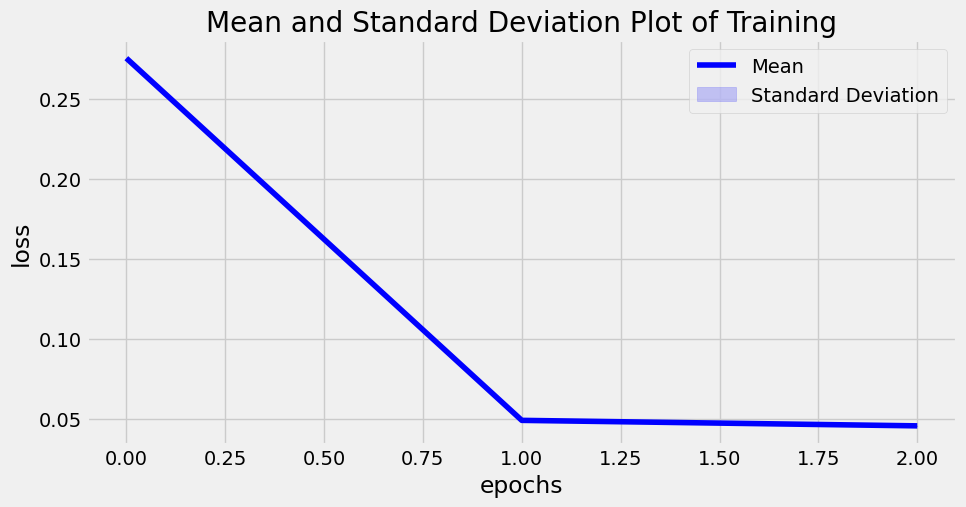

[0.27538183 0.07530268 0.07752126] [0.00011272 0.03688652 0.03752229]


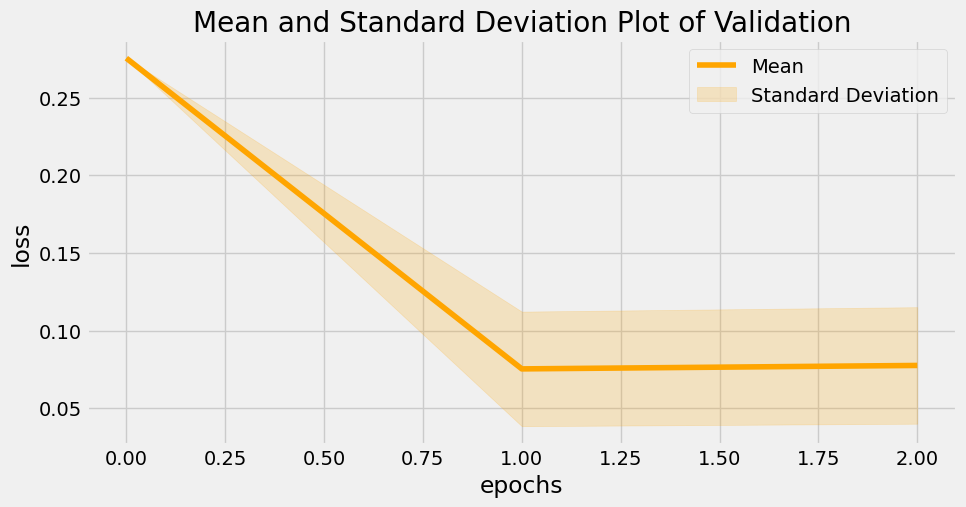

In [1525]:
# Defining the Plot Style

# Plotting
with torch.no_grad():
    plot_mean_and_std(losses_2d, "blue", "Training")
    plot_mean_and_std(val_losses_2d, "orange", "Validation")

# wandb.log(
#     {
#         "train val loss": wandb.plot.line_series(
#             xs=range(1, epochs + 1),
#             ys=[losses, val_losses],
#             keys=["Train", "Validation"],
#             title="training and validation loss",
#             xname="epochs",
#         )
#     }
# )

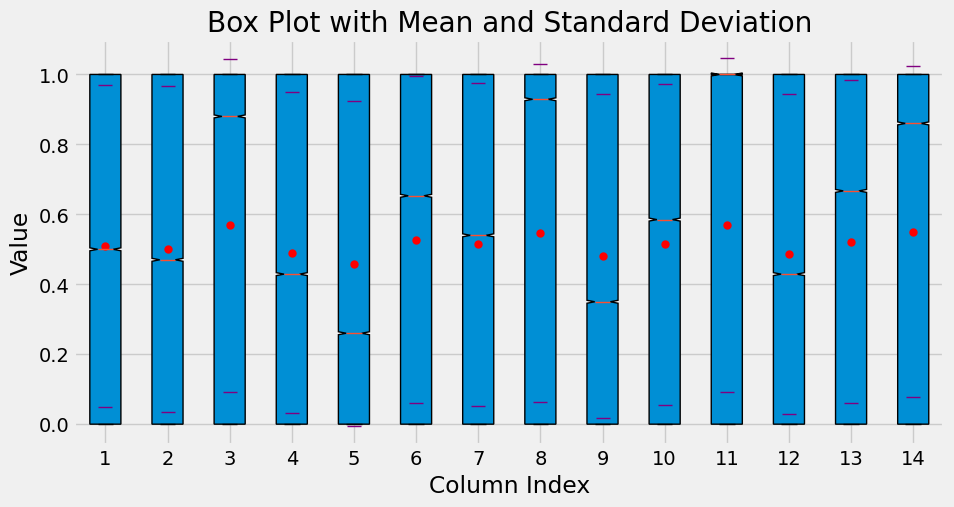

In [1526]:
def enhanced_box_plot(data_array):
    """
    Creates a box plot for each column in the given NumPy array and overlays mean and standard deviation.
    
    Parameters:
    - data_array (numpy.ndarray): A 2D NumPy array where each column represents a series of data points.
    """
    fig, ax = plt.subplots(figsize=(10, 5))
    # Create the boxplot
    bp = ax.boxplot(data_array, patch_artist=True, notch=True, meanline=True)
    
    # Calculate means and standard deviations
    means = np.mean(data_array, axis=0)
    stds = np.std(data_array, axis=0)
    n_cols = data_array.shape[1]

    # Add mean and standard deviation lines
    for i in range(n_cols):
        # Mean line
        plt.plot([i+1], [means[i]], color='red', marker='o', markersize=5)
        # Standard deviation lines
        plt.plot([i+1, i+1], [means[i] - stds[i], means[i] + stds[i]], color='purple', marker='_', markersize=10, linestyle='None')

    # Customizing the plot
    plt.title('Box Plot with Mean and Standard Deviation')
    plt.xlabel('Column Index')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()

enhanced_box_plot(model_data[:, 0::2])

In [1527]:
np.mean(x_train, axis=0)

array([0.51189779, 0.49256853, 0.50140865, 0.49095159, 0.56796514,
       0.42770077, 0.49255695, 0.5066203 , 0.46002984, 0.54406918,
       0.52626372, 0.47473533, 0.51422527, 0.48360034, 0.54614746,
       0.45169284, 0.47943269, 0.5200531 , 0.51487247, 0.48630287,
       0.56973048, 0.42952024, 0.4866006 , 0.51347286, 0.52361425,
       0.47770801, 0.55058045, 0.45272522])

In [1528]:
zero_test = np.zeros((5000, 14))

In [1529]:
temp = np.zeros((5000, 14*2))
for i in range(5000):
    for d in range(14):
        p = zero_test[i, d]
        # update output array
        if p == 0:
            # print("shouldn't be here")
            missing_ind = np.random.choice(2, 1)[0]
            temp[i, d*2] = missing_ind
            temp[i, d*2+1] = missing_ind
        else:
            temp[i, d*2] = p # score
            temp[i, d*2+1] = 1-p # 1-score

zero_test = copy.deepcopy(temp)

In [1530]:
model.eval()
total = np.zeros((1, 28))
with torch.no_grad():
    for row in zero_test:
        temp = row.reshape(-1, 14 * 2)
        temp = torch.from_numpy(temp)
        temp = temp.clone().detach().type(torch.float32)
        output = model(temp).detach().numpy()[0]
        total = output + total

total = total/5000
total

array([[0.51694712, 0.48314364, 0.50245721, 0.49750158, 0.85084672,
        0.14913671, 0.43857104, 0.56139501, 0.26973291, 0.73021892,
        0.58538548, 0.41457115, 0.55305023, 0.44697062, 0.69844465,
        0.30154762, 0.37589461, 0.62409933, 0.55584439, 0.44416425,
        0.84435504, 0.15570354, 0.41820865, 0.5817924 , 0.60951688,
        0.39047036, 0.74767643, 0.25236411]])

In [1531]:
from sklearn.metrics import mean_squared_error
mean_squared_error(np.reshape(np.mean(x_train, axis=0), (total.shape)), total)

0.020320726216150282

### See how this changes the score trajectory

In [1532]:
data

,id,patient_id,domain_ids,domain_scores,start_time_min,domain 1 score,domain 2 score,domain 3 score,domain 4 score,domain 5 score,domain 6 score,domain 7 score,domain 8 score,domain 9 score,domain 10 score,domain 11 score,domain 12 score,domain 13 score,domain 14 score
0,9316748,14696,"1,13","0.5850,0.7030",2017-12-06 14:20:08,0.585,0.0,0.00,0.000,0.000,0.0,0.0,0.0,0.00,0.000,0.0,0.000,0.703,0.0
1,9316749,14696,"4,5","0.6430,0.4500",2017-12-06 14:27:53,0.585,0.0,0.00,0.643,0.450,0.0,0.0,0.0,0.00,0.000,0.0,0.000,0.703,0.0
2,9316750,14696,9,0.9500,2017-12-06 14:38:16,0.585,0.0,0.00,0.643,0.450,0.0,0.0,0.0,0.95,0.000,0.0,0.000,0.703,0.0
3,9316751,14696,10,0.8070,2017-12-06 14:44:54,0.585,0.0,0.00,0.643,0.450,0.0,0.0,0.0,0.95,0.807,0.0,0.000,0.703,0.0
4,9316752,14696,"12,13","0.5070,0.7030",2017-12-06 14:50:15,0.585,0.0,0.00,0.643,0.450,0.0,0.0,0.0,0.95,0.807,0.0,0.507,0.703,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2194129,25142627,408963,5,0.6130,2020-06-26 06:55:04,0.000,0.0,0.63,0.800,0.613,0.0,0.0,0.0,0.00,0.000,0.0,0.000,0.454,0.0
2194130,25142628,408963,5,0.6260,2020-06-26 06:55:13,0.000,0.0,0.63,0.800,0.626,0.0,0.0,0.0,0.00,0.000,0.0,0.000,0.454,0.0
2194131,25142634,408963,5,0.6520,2020-06-26 07:01:30,0.000,0.0,0.63,0.800,0.652,0.0,0.0,0.0,0.00,0.000,0.0,0.000,0.454,0.0
2194132,25157982,408963,5,0.6900,2020-07-03 23:15:37,0.000,0.0,0.63,0.800,0.690,0.0,0.0,0.0,0.00,0.000,0.0,0.000,0.454,0.0


In [1533]:
import random
pid = random.choice(pd.unique(data["patient_id"]))
pid

263332

In [1534]:
pid = 286788

In [1535]:
column_names = ["domain %d score" % i for i in range(1, 15)]

In [1536]:
data[data.patient_id == pid]

,id,patient_id,domain_ids,domain_scores,start_time_min,domain 1 score,domain 2 score,domain 3 score,domain 4 score,domain 5 score,domain 6 score,domain 7 score,domain 8 score,domain 9 score,domain 10 score,domain 11 score,domain 12 score,domain 13 score,domain 14 score
1961628,17453525,286788,"4,5","0.2860,0.1000",2019-05-04 11:30:23,0.0,0.0,0.0,0.286,0.100,0.000,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0
1961629,18000567,286788,9,0.2750,2019-06-08 11:26:39,0.0,0.0,0.0,0.286,0.100,0.000,0.0,0.0,0.275,0.000,0.0,0.0,0.0,0.0
1961630,18276619,286788,"4,5","0.3100,0.1500",2019-06-16 02:09:32,0.0,0.0,0.0,0.310,0.150,0.000,0.0,0.0,0.275,0.000,0.0,0.0,0.0,0.0
1961631,18276620,286788,5,0.1500,2019-06-16 02:12:17,0.0,0.0,0.0,0.310,0.150,0.000,0.0,0.0,0.275,0.000,0.0,0.0,0.0,0.0
1961632,18409802,286788,5,0.1750,2019-06-23 13:04:43,0.0,0.0,0.0,0.310,0.175,0.000,0.0,0.0,0.275,0.000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1961691,21507983,286788,5,0.6130,2019-12-06 22:33:44,0.0,0.0,0.0,0.571,0.613,0.467,0.0,0.0,0.400,0.764,1.0,0.0,0.0,0.0
1961692,21507985,286788,6,0.5070,2019-12-11 21:45:37,0.0,0.0,0.0,0.571,0.613,0.507,0.0,0.0,0.400,0.764,1.0,0.0,0.0,0.0
1961693,21593000,286788,6,0.6130,2019-12-11 23:24:07,0.0,0.0,0.0,0.571,0.613,0.613,0.0,0.0,0.400,0.764,1.0,0.0,0.0,0.0
1961694,21593004,286788,5,0.6390,2019-12-11 23:32:13,0.0,0.0,0.0,0.571,0.639,0.613,0.0,0.0,0.400,0.764,1.0,0.0,0.0,0.0


In [1537]:
def get_score(data : pd.DataFrame):
    updated_domain_pct = dict() # keeps updated domain pct
    score = 0 # score for each session, an average of all available domains
    scores = []

    data = data.sort_values(by="start_time_min").reset_index(drop=True)
    column_names = ["domain %d score" % i for i in range(1, 15)]

    for idx, row in data.iterrows():
        domain_ids, _ = process_row(row)
        for j in range(len(domain_ids)):
            col = column_names[int(domain_ids[j] - 1)]
            updated_domain_pct[col] = row[col] # update domain pct to the latest one
        # find sum of all domain pct
        for k, v in updated_domain_pct.items():
            score += float(v)
        # take average of domain pct, add to list, reset score to 0
        score /= len(updated_domain_pct)
        scores.append(score)
        score = 0
    # return scores list
    return scores

In [1538]:
no_pred_scores = get_score(data[data.patient_id == pid])

In [1539]:
temp = data[data.patient_id == pid].copy(deep=True)
patient_data = temp.sort_values(by='start_time_min').reset_index()
patient_data_scores = patient_data[column_names].to_numpy()
patient_data_scores.shape

(68, 14)

In [1540]:
l, w = patient_data_scores.shape

In [1541]:
temp = np.zeros((l, w*2))
for i in range(l):
    for d in range(w):
        p = patient_data_scores[i, d]
        # update output array
        if p == 0:
            # print("shouldn't be here")
            missing_ind = np.random.choice(2, 1)[0]
            temp[i, d*2] = missing_ind
            temp[i, d*2+1] = missing_ind
        else:
            temp[i, d*2] = p # score
            temp[i, d*2+1] = 1-p # 1-score

patient_data_scores = copy.deepcopy(temp)

In [1542]:
input_tensor = torch.tensor(patient_data_scores, dtype=torch.float32)

predictions = []

for row in input_tensor:
    # Reshape row to (1, 28) if necessary
    row = row.unsqueeze(0) if len(row.shape) == 1 else row
    # Forward pass through the model
    with torch.no_grad():
        # print(model(row))
        output = model(row)
        
    # Append predictions to the list
    predictions.append(output.numpy())

predictions = np.array(predictions)

In [1543]:
predictions = predictions.reshape(l, w * 2)
predictions = predictions[:, ::2]

In [1544]:
patient_data.iloc[:, -14:] = predictions

In [1545]:
patient_data['score'] = patient_data.iloc[:, -14:].mean(axis=1)

In [1546]:
patient_data["no_pred_score"] = no_pred_scores

In [1547]:
patient_data["start_time_min"] = pd.to_datetime(patient_data["start_time_min"])

Text(0.5, 1.0, '286788')

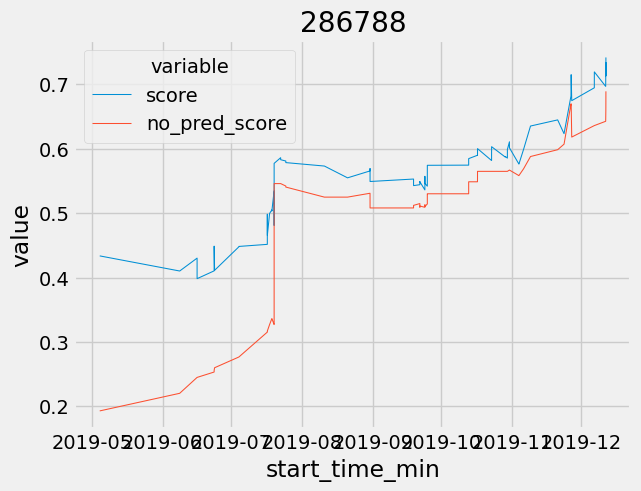

In [1548]:
sns.lineplot(x="start_time_min", y="value", hue='variable', data=pd.melt(patient_data[["start_time_min", "score", "no_pred_score"]], ['start_time_min']),linewidth=0.75).set_title(pid)

In [1549]:
# torch.save(model.state_dict(), "model/model.pt")
# artifact = wandb.Artifact('model', type='model')
# artifact.add_file('model/model.pt')
# run.log_artifact(artifact)

In [1550]:
# wandb.unwatch()
# wandb.finish()